In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import descartes
import shapely.wkt
import pyproj

from shapely.geometry import Point

In [7]:
prop = pd.read_csv(r"C:\Users\RedRagon\Documents\ProjetoIntegrador1\Data\Real_State_Properati.csv",sep='\t')

In [8]:
prop.shape

(17223, 9)

In [9]:
prop.head(5)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0
2,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,138000.0,USD,45.0
3,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,195000.0,USD,65.0
4,PH,Mataderos,Argentina,Capital Federal,-34.652356,-58.501624,239000.0,USD,140.0


In [10]:
prop.isna().sum()

property_type          0
place_name             0
country_name           0
state_name             0
lat                    0
lon                    0
price                  0
currency               0
surface_total_in_m2    0
dtype: int64

In [11]:
prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17223 entries, 0 to 17222
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_type        17223 non-null  object 
 1   place_name           17223 non-null  object 
 2   country_name         17223 non-null  object 
 3   state_name           17223 non-null  object 
 4   lat                  17223 non-null  float64
 5   lon                  17223 non-null  float64
 6   price                17223 non-null  float64
 7   currency             17223 non-null  object 
 8   surface_total_in_m2  17223 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.2+ MB


In [12]:
for col in prop.columns:
    print(col, "-", len(prop[col].unique()))

property_type - 4
place_name - 62
country_name - 1
state_name - 1
lat - 9714
lon - 9704
price - 2754
currency - 2
surface_total_in_m2 - 568


In [13]:
prop['property_type'].unique()

array(['PH', 'apartment', 'house', 'store'], dtype=object)

In [14]:
prop.groupby(by = 'property_type').count()['place_name'].sort_values(ascending = False)

property_type
apartment    14428
PH            1142
house          888
store          765
Name: place_name, dtype: int64

In [15]:
prop['property_type'].value_counts()/len(prop['property_type'])*100

apartment    83.771701
PH            6.630668
house         5.155896
store         4.441735
Name: property_type, dtype: float64

In [16]:
prop.groupby(by = 'currency').count()['place_name'].sort_values(ascending = False)

currency
USD    16700
ARS      523
Name: place_name, dtype: int64

In [17]:
prop['currency'].value_counts()/len(prop['currency'])*100

USD    96.963363
ARS     3.036637
Name: currency, dtype: float64

In [18]:
prop["price_usd"] = prop.apply(lambda x: x["price"] if x["currency"] == "USD" else x["price"]/117.41,axis=1)

In [19]:
prop.columns

Index(['property_type', 'place_name', 'country_name', 'state_name', 'lat',
       'lon', 'price', 'currency', 'surface_total_in_m2', 'price_usd'],
      dtype='object')

In [20]:
prop["preco_metro2"] = prop.price_usd / prop.surface_total_in_m2

In [21]:
prop.shape

(17223, 11)

In [22]:
prop[(prop.property_type == 'apartment') & (prop.surface_total_in_m2 == 0)]

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,price_usd,preco_metro2
2486,apartment,Palermo Soho,Argentina,Capital Federal,-34.589974,-58.425614,780000.0,USD,0.0,780000.0,inf
4872,apartment,Recoleta,Argentina,Capital Federal,-34.588818,-58.390648,320000.0,USD,0.0,320000.0,inf
5454,apartment,Caballito,Argentina,Capital Federal,-34.617348,-58.449404,68500.0,USD,0.0,68500.0,inf
6318,apartment,Palermo Hollywood,Argentina,Capital Federal,-34.582558,-58.432585,175000.0,USD,0.0,175000.0,inf
7170,apartment,Barracas,Argentina,Capital Federal,-34.641131,-58.369122,135000.0,USD,0.0,135000.0,inf
15888,apartment,Barrio Norte,Argentina,Capital Federal,-34.598727,-58.395851,112000.0,USD,0.0,112000.0,inf


In [23]:
prop.drop(index = list(prop[(prop.property_type == 'apartment') & (prop.surface_total_in_m2 == 0)].index),inplace = True)

In [24]:
for i in prop.property_type.unique():
    prop.drop(index = list(prop.loc[(prop.property_type == i) & (prop.preco_metro2 > 3*prop.preco_metro2.std())].index), inplace = True)

In [25]:
prop.columns

Index(['property_type', 'place_name', 'country_name', 'state_name', 'lat',
       'lon', 'price', 'currency', 'surface_total_in_m2', 'price_usd',
       'preco_metro2'],
      dtype='object')

In [26]:
prop.shape

(16770, 11)

In [27]:
df_bairros = pd.read_csv("Data/Neighborhoods.csv", encoding = 'latin1')
df_bairros.head()

,WKT,NEIGHBORHOOD,COMMUNE,PERIMETER,AREA
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,15.0,7725.695228,3.118101e+06
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,15.0,7087.513295,2.229829e+06
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,15.0,8132.699348,3.613584e+06
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06
4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",ALMAGRO,5.0,8537.901368,4.050752e+06


In [28]:
df_bairros["WKT"] = df_bairros["WKT"].apply(shapely.wkt.loads)
geo_bairros = gpd.GeoDataFrame(df_bairros, geometry = 'WKT' )
type(geo_bairros)

geopandas.geodataframe.GeoDataFrame

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


<AxesSubplot:>

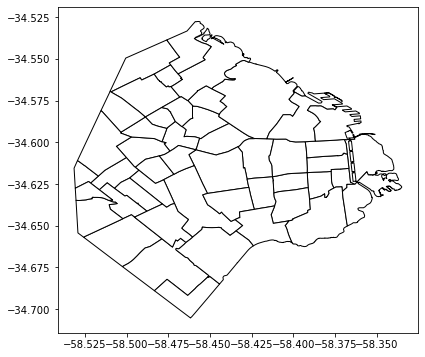

In [29]:
geo_bairros.plot(color = 'white', edgecolor='black', figsize=(10,6))

In [30]:
geometria = gpd.points_from_xy(prop['lon'],prop['lat'])

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\geopandas\array.py:253: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [31]:
prop = gpd.GeoDataFrame(prop,
                        geometry = geometria
                        )

In [32]:
prop.loc[ : , ['geometry', 'lat', 'lon', 'property_type', 'place_name']]

,geometry,lat,lon,property_type,place_name
0,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
1,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
2,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
3,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
4,POINT (-58.50162 -34.65236),-34.652356,-58.501624,PH,Mataderos
...,...,...,...,...,...
17218,POINT (-58.40252 -34.59921),-34.599214,-58.402519,apartment,Barrio Norte
17219,POINT (-58.39737 -34.58743),-34.587425,-58.397372,apartment,Recoleta
17220,POINT (-58.44268 -34.56369),-34.563685,-58.442683,apartment,Belgrano
17221,POINT (-58.44268 -34.56369),-34.563685,-58.442683,apartment,Belgrano


In [33]:
prop['property_place'] = prop['property_type'] + '_' + prop['place_name']

In [34]:
prop['avg_price_m2'] = prop.groupby('property_place')['preco_metro2'].transform('mean')

In [35]:
prop.head(2)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,price_usd,preco_metro2,geometry,property_place,avg_price_m2
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0,62000.0,1127.272727,POINT (-58.50884 -34.66182),PH_Mataderos,1386.591733
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0,72000.0,1309.090909,POINT (-58.52298 -34.65226),apartment_Mataderos,1776.706933


C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
C:\U

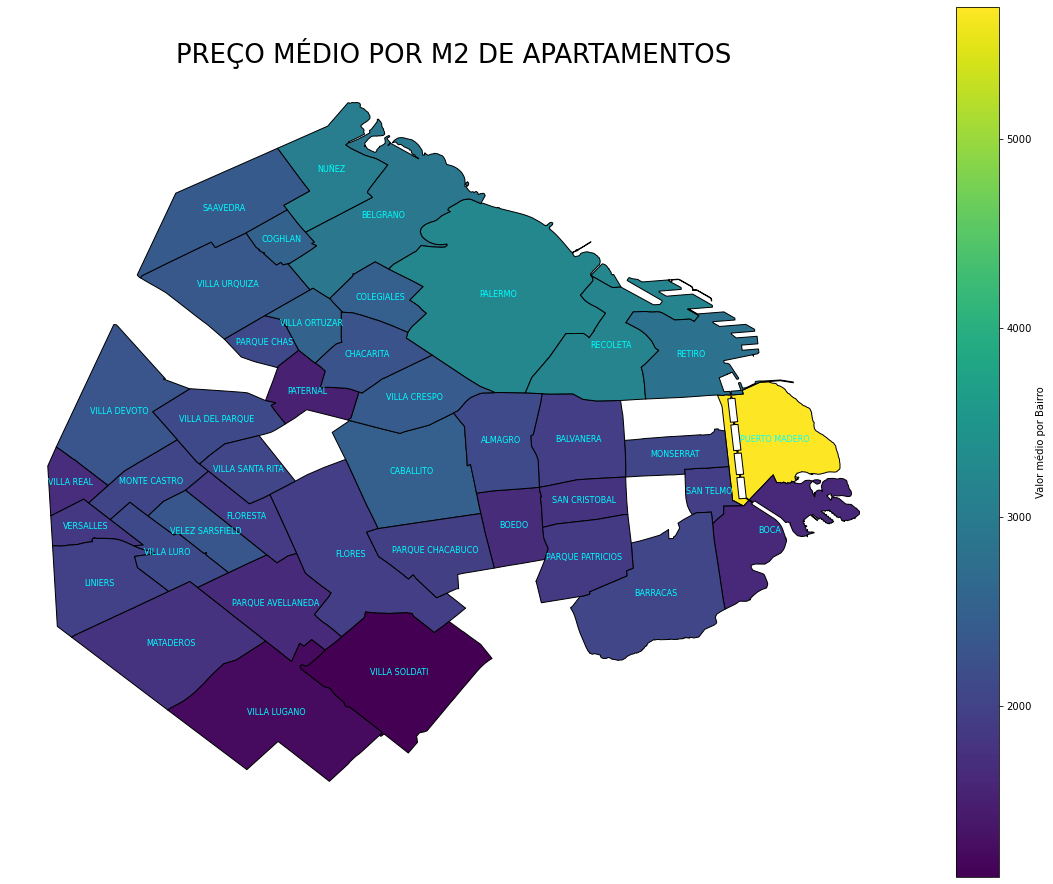

In [36]:
df_apart = prop.loc[ : , ['property_type', 'place_name', 'avg_price_m2']]

avg_bairro_apart = df_apart.loc[df_apart['property_type'] == 'apartment']
avg_bairro_apart['place_name'] = avg_bairro_apart['place_name'].str.upper()

geodata_apart = pd.merge(left=avg_bairro_apart, right=df_bairros, left_on='place_name', right_on='NEIGHBORHOOD', how='inner')
geodata_apart = geodata_apart.rename(columns={"WKT": "geometry"})
geodata_apart = geodata_apart.drop(columns=['NEIGHBORHOOD','COMMUNE','PERIMETER','AREA'])
geodata_apart = geodata_apart.drop_duplicates(subset=['place_name'])

geodf_apart = gpd.GeoDataFrame(geodata_apart)

ax = geodf_apart.loc[geodf_apart['property_type'] == 'apartment'].plot(
    figsize=(20,16),
    edgecolor='black',column='avg_price_m2',
    legend=True,
    legend_kwds={'label': "Valor médio por Bairro",'orientation':"vertical" })

for i in geodf_apart.index:
    plt.text(geodf_apart.geometry.centroid[i].coords[0][0], geodf_apart.geometry.centroid[i].coords[0][1], geodf_apart.place_name[i],
             fontsize=8, horizontalalignment='center', verticalalignment='center', color = 'cyan')
    
ax.set_axis_off();
ax.set_title("PREÇO MÉDIO POR M2 DE APARTAMENTOS",fontsize=26);

### AGORA COMEÇA A REGREÇÃO

In [37]:
prop.head(2)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,price_usd,preco_metro2,geometry,property_place,avg_price_m2
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0,62000.0,1127.272727,POINT (-58.50884 -34.66182),PH_Mataderos,1386.591733
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0,72000.0,1309.090909,POINT (-58.52298 -34.65226),apartment_Mataderos,1776.706933


In [35]:
prop.drop(columns=['price', 'currency','price_usd','avg_price_m2','property_place'], inplace= True)

In [36]:
prop.columns

Index(['property_type', 'place_name', 'country_name', 'state_name', 'lat',
       'lon', 'surface_total_in_m2', 'preco_metro2', 'geometry'],
      dtype='object')

In [38]:
aa = prop[prop.place_name == 'Retiro']
a = aa[aa.property_type == 'apartment']
bb = prop[prop.place_name == 'Recoleta']
b = bb[bb.property_type == 'apartment']
cc = prop[prop.place_name == 'Palermo']
c = cc[cc.property_type == 'apartment']
dd = prop[prop.place_name == 'Belgrano']
d = dd[dd.property_type == 'apartment']
ee = prop[prop.place_name == 'Nuñez']
e = ee[ee.property_type == 'apartment']
df_analise = pd.concat([a,b,c,d,e])
df212 = df_analise.sort_values(by='place_name')
dummiess = pd.get_dummies(df212.place_name)
data22 = pd.concat([df212, dummiess],axis=1)
data = data22.drop(columns = ['geometry','place_name'])
dumies = pd.get_dummies(data.property_type)
df = pd.concat([data,dumies],axis =1)
df = df.drop(columns = ['property_type','apartment'])
df

,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,price_usd,preco_metro2,property_place,avg_price_m2,Belgrano,Nuñez,Palermo,Recoleta,Retiro
10106,Argentina,Capital Federal,-34.555270,-58.455786,180000.0,USD,77.0,180000.0,2337.662338,apartment_Belgrano,2921.998257,1,0,0,0,0
11109,Argentina,Capital Federal,-34.560210,-58.469261,210000.0,USD,111.0,210000.0,1891.891892,apartment_Belgrano,2921.998257,1,0,0,0,0
11110,Argentina,Capital Federal,-34.560210,-58.469261,114210.0,USD,42.0,114210.0,2719.285714,apartment_Belgrano,2921.998257,1,0,0,0,0
11112,Argentina,Capital Federal,-34.560210,-58.469261,230000.0,USD,98.0,230000.0,2346.938776,apartment_Belgrano,2921.998257,1,0,0,0,0
11113,Argentina,Capital Federal,-34.560210,-58.469261,263000.0,USD,113.0,263000.0,2327.433628,apartment_Belgrano,2921.998257,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9444,Argentina,Capital Federal,-34.597040,-58.378666,199555.0,USD,52.0,199555.0,3837.596154,apartment_Retiro,2818.160767,0,0,0,0,1
9582,Argentina,Capital Federal,-34.586849,-58.384689,470000.0,USD,161.0,470000.0,2919.254658,apartment_Retiro,2818.160767,0,0,0,0,1
9919,Argentina,Capital Federal,-34.592865,-58.381134,500000.0,USD,166.0,500000.0,3012.048193,apartment_Retiro,2818.160767,0,0,0,0,1
10455,Argentina,Capital Federal,-34.591852,-58.376688,230000.0,USD,70.0,230000.0,3285.714286,apartment_Retiro,2818.160767,0,0,0,0,1


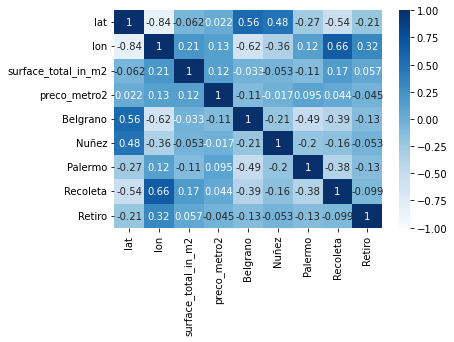

In [39]:
sns.heatmap(df.corr(), 
            annot = True, 
            vmin = -1, 
            cmap = 'Blues'
            );


<AxesSubplot:>

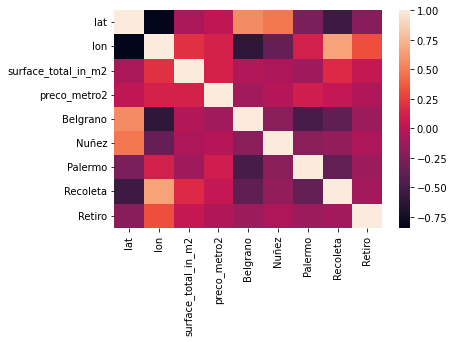

In [40]:
sns.heatmap(df.corr())

In [47]:
df.columns

Index(['country_name', 'state_name', 'lat', 'lon', 'surface_total_in_m2',
       'preco_metro2', 'Belgrano', 'Nuñez', 'Palermo', 'Recoleta', 'Retiro'],
      dtype='object')

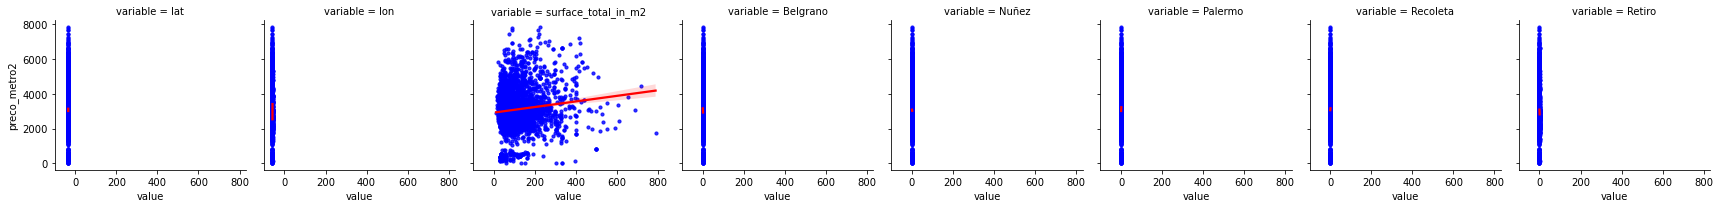

In [49]:
df_grid = pd.melt(df, id_vars = 'preco_metro2', value_vars = ['lat', 'lon', 'surface_total_in_m2','Belgrano', 'Nuñez', 'Palermo', 'Recoleta', 'Retiro'])
g = sns.FacetGrid(df_grid, col = "variable")
g.map(sns.regplot, "value", "preco_metro2", ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"});

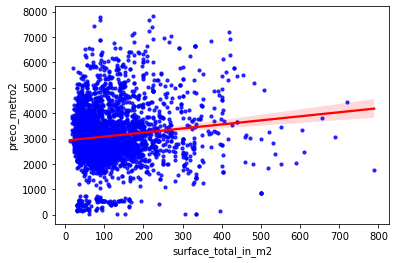

In [52]:
sns.regplot(data = df, x = "surface_total_in_m2", y = "preco_metro2", ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"});

In [70]:
import statsmodels.api as sm
feature_cols = ['lat', 'lon', 'surface_total_in_m2','Belgrano', 'Nuñez', 'Palermo', 'Recoleta', 'Retiro']
X = df[feature_cols]
y = df.preco_metro2
# Temos que adicionar explicitamente a uma constante:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()


In [71]:
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:           preco_metro2   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     74.38
Date:                Thu, 30 Jun 2022   Prob (F-statistic):          1.01e-101
Time:                        12:14:57   Log-Likelihood:                -33858.
No. Observations:                4073   AIC:                         6.773e+04
Df Residuals:                    4065   BIC:                         6.778e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.107e+06   1

In [68]:
X_t = np.array(df.surface_total_in_m2, ndmin = 2)
X = np.transpose(X_t)
y = df.preco_metro2
# Temos que adicionar explicitamente a uma constante:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

In [69]:
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:           preco_metro2   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     63.82
Date:                Thu, 30 Jun 2022   Prob (F-statistic):           1.76e-15
Time:                        12:14:53   Log-Likelihood:                -34072.
No. Observations:                4073   AIC:                         6.815e+04
Df Residuals:                    4071   BIC:                         6.816e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2916.4157     26.167    111.453      0.0

In [62]:
df.columns

Index(['country_name', 'state_name', 'lat', 'lon', 'surface_total_in_m2',
       'preco_metro2', 'Belgrano', 'Nuñez', 'Palermo', 'Recoleta', 'Retiro'],
      dtype='object')

In [67]:
correlations = np.corrcoef(np.transpose(df))
print(correlations)
print(df.columns)

[[ 1.         -0.84158419 -0.06182598  0.02188881  0.55915538  0.47741854
  -0.27210768 -0.54158955 -0.21231705]
 [-0.84158419  1.          0.2074892   0.12636385 -0.61694441 -0.35889755
   0.11911775  0.65700463  0.31862989]
 [-0.06182598  0.2074892   1.          0.12423895 -0.03342108 -0.05337431
  -0.11064985  0.17117112  0.05686847]
 [ 0.02188881  0.12636385  0.12423895  1.         -0.1074087  -0.01650743
   0.09548338  0.04373737 -0.04521445]
 [ 0.55915538 -0.61694441 -0.03342108 -0.1074087   1.         -0.20717906
  -0.49352334 -0.38834261 -0.12875487]
 [ 0.47741854 -0.35889755 -0.05337431 -0.01650743 -0.20717906  1.
  -0.20173396 -0.15874    -0.0526302 ]
 [-0.27210768  0.11911775 -0.11064985  0.09548338 -0.49352334 -0.20173396
   1.         -0.37813616 -0.12537093]
 [-0.54158955  0.65700463  0.17117112  0.04373737 -0.38834261 -0.15874
  -0.37813616  1.         -0.09865161]
 [-0.21231705  0.31862989  0.05686847 -0.04521445 -0.12875487 -0.0526302
  -0.12537093 -0.09865161  1.     

In [72]:
feature_cols = ['lat', 'lon', 'surface_total_in_m2','Belgrano', 'Nuñez', 'Palermo', 'Recoleta', 'Retiro']
X = df[feature_cols]
y = df.preco_metro2
# Temos que adicionar explicitamente uma constante:
X = sm.add_constant(X)
model_no_interaccion = sm.OLS(y, X).fit()

In [73]:
print (model_no_interaccion.summary())

                            OLS Regression Results                            
Dep. Variable:           preco_metro2   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     74.38
Date:                Thu, 30 Jun 2022   Prob (F-statistic):          1.01e-101
Time:                        12:15:47   Log-Likelihood:                -33858.
No. Observations:                4073   AIC:                         6.773e+04
Df Residuals:                    4065   BIC:                         6.778e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.107e+06   1

In [79]:
df["lat_x_lon"] = df.lat * df.lon
feature_cols = ['lat', 'lon', 'surface_total_in_m2','Belgrano', 'Nuñez', 'Palermo', 'Recoleta', 'Retiro',"lat_x_lon"]
X = df[feature_cols]
y = df.preco_metro2
# Temos que adicionar explicitamente uma constante:
X = sm.add_constant(X)
model_interaccion = sm.OLS(y, X).fit()

In [80]:
print (model_interaccion.summary())

                            OLS Regression Results                            
Dep. Variable:           preco_metro2   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     68.60
Date:                Thu, 30 Jun 2022   Prob (F-statistic):          3.94e-106
Time:                        12:19:52   Log-Likelihood:                -33845.
No. Observations:                4073   AIC:                         6.771e+04
Df Residuals:                    4064   BIC:                         6.777e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                5.241e+08   1

In [43]:
feature_cols = ['Belgrano', 'Nuñez', 'Palermo', 'Recoleta', 'Retiro', 'surface_total_in_m2']
X = df[feature_cols]
y = df.preco_metro2
print('X:',X.shape)
print('y:',y.shape)


X: (4073, 6)
y: (4073,)


In [ ]:
model.score(X,y)

NameError: name 'model' is not defined

In [ ]:
print (model.intercept_)
print (model.coef_)

NameError: name 'model' is not defined

In [ ]:
pred = model.predict(X)

In [ ]:
from sklearn import metrics
import numpy as np
print ('MAE:', metrics.mean_absolute_error(y, pred))
print ('MSE:', metrics.mean_squared_error(y, pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y, pred)))
print ('R2:', metrics.r2_score(y, pred))

MAE: 729.379518044871
MSE: 1060089.051135638
RMSE: 1029.6062602449724
R2: 0.03372452922857838


In [94]:
#datacul = datacul.drop(columns =['Modalidad','barrio ','publico_objetivo','Gratuita'])
#datacul = datacul.rename(columns={'long':'lon'})
datacul.dropna()

,lugar,lon,lat
0,CLUB ARQUITECTURA,-58.485091,-34.589483
3,CLUB ARQUITECTURA,-58.485091,-34.589483
5,CLUB ARQUITECTURA,-58.485091,-34.589483
6,CLUB ARQUITECTURA,-58.485091,-34.589483
7,ABASTO,-58.411406,-34.602940
...,...,...,...
2897,CENTRO CULTURAL RECOLETA,-58.391578,-34.586496
2898,PLAZA ALMAGRO,-58.419732,-34.605048
2902,MUSEO DE ARTE MODERNO DE BUENOS AIRES,-58.370727,-34.621892
2903,MUSEO DE ARTE ESPAÑOL ENRIQUE LARRETA,-58.455265,-34.561129


In [90]:
df_cultura = pd.read_csv("Data/actividades-culturales-2021.csv",sep=';')
cultura = df_cultura.drop(columns = ['descripcion_actividad','actividad','dirección','calle','altura','comuna','fecha_ini','fecha_fin','tipo','tipo_actividad','disciplina','se_suspende_por_lluvia','Links'])
datacul = cultura[cultura.Modalidad == 'Presencial']
datacul.shape

(2178, 7)

In [36]:
datacul = datacul.dropna()
datacul.shape

(2152, 7)

In [84]:
datacul = datacul.drop(columns = ['Modalidad','publico_objetivo','Gratuita'])

In [85]:
datacul = datacul.rename(columns={'barrio ': 'barrio','long':'lon'})
datacul.barrio

0       AGRONOMIA
3       AGRONOMIA
5       AGRONOMIA
6       AGRONOMIA
7       BALVANERA
          ...    
2897     RECOLETA
2898      ALMAGRO
2902    SAN TELMO
2903     BELGRANO
2904    BALVANERA
Name: barrio, Length: 2152, dtype: object

In [86]:
f = datacul[datacul.barrio== 'RETIRO']
g = datacul[datacul.barrio == 'RECOLETA']
h = datacul[datacul.barrio == 'PALERMO']
i = datacul[datacul.barrio == 'BELGRANO']
j = datacul[datacul.barrio == 'NUÑES']
df_cul = pd.concat([f,g,h,i,j])
df_cul
d = pd.get_dummies(df_cul.barrio)
df_cul = pd.concat([df_cul, d],axis=1)
df_cul = df_cul.drop(columns = ['barrio'])
k = pd.get_dummies(df_cul.lugar)
df_cul = pd.concat([df_cul, k],axis=1)
df_cul = df_cul.drop(columns = ['lugar'])
df_cul = df_cul.rename(columns={'BELGRANO': 'Belgrano',
                                'PALERMO':'Palermo',
                                'RECOLETA':'Recoleta',
                                'RETIRO':'Retiro'})
df_cul

,lon,lat,Belgrano,Palermo,Recoleta,Retiro,ALTO PALERMO SHOPPING,BARRIO 31,BIBLIOTECA CARLOS GUIDO Y SPANO,BIBLIOTECA LEOPOLDO LUGONES,...,MULTIPLEX BELGRANO,MUSEO DE ARTE ESPAÑOL ENRIQUE LARRETA,MUSEO DE ARTE HISPANOAMÉRICANO ISAAC FERNÁNDEZ BLANCO,MUSEO FERNANDEZ BLANCO,MUSEO FERNÁNDEZ BLANCO,MUSEO SÍVORI,"PALERMO, MARTÍN CORONADO Y SALGUERO",PARQUE DE LA MEMORIA,SUCRE ESQUINA POESÍA,TEATRO SARMIENTO
109,-58.379932,-34.590901,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
110,-58.379932,-34.590901,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
116,-58.379932,-34.590901,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
117,-58.379932,-34.590901,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
122,-58.379932,-34.590901,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972,-58.455265,-34.561129,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1973,-58.455265,-34.561129,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2539,-58.452595,-34.563839,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2873,-58.430948,-34.546607,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [87]:
df_analise = pd.concat([df,df_cul])
df_analise.describe()

,lat,lon,surface_total_in_m2,preco_metro2,Belgrano,Nuñez,Palermo,Recoleta,Retiro,lat_x_lon,...,MULTIPLEX BELGRANO,MUSEO DE ARTE ESPAÑOL ENRIQUE LARRETA,MUSEO DE ARTE HISPANOAMÉRICANO ISAAC FERNÁNDEZ BLANCO,MUSEO FERNANDEZ BLANCO,MUSEO FERNÁNDEZ BLANCO,MUSEO SÍVORI,"PALERMO, MARTÍN CORONADO Y SALGUERO",PARQUE DE LA MEMORIA,SUCRE ESQUINA POESÍA,TEATRO SARMIENTO
count,4567.000000,4567.000000,4073.000000,4073.000000,4567.000000,4073.000000,4567.000000,4567.000000,4567.000000,4073.000000,...,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000
mean,-34.576712,-58.426434,102.341763,3080.022206,0.313992,0.078075,0.330414,0.248084,0.037880,2020.242540,...,0.006073,0.111336,0.018219,0.032389,0.016194,0.119433,0.004049,0.006073,0.002024,0.113360
std,0.015480,0.028236,81.411173,1047.548206,0.464164,0.268323,0.470414,0.431948,0.190928,0.536583,...,0.077770,0.314867,0.133877,0.177210,0.126350,0.324626,0.063564,0.077770,0.044992,0.317354
min,-34.626499,-58.544722,12.000000,27.376592,0.000000,0.000000,0.000000,0.000000,0.000000,2018.776772,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-34.589546,-58.452120,47.000000,2544.642857,0.000000,0.000000,0.000000,0.000000,0.000000,2019.857383,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-34.578695,-58.424135,77.000000,2962.962963,0.000000,0.000000,0.000000,0.000000,0.000000,2020.213493,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-34.563730,-58.400617,128.000000,3520.408163,1.000000,0.000000,1.000000,0.000000,0.000000,2020.551803,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,-34.536155,-58.359591,789.000000,7812.500000,1.000000,1.000000,1.000000,1.000000,1.000000,2024.533911,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [88]:
df_analise.columns

Index(['lat', 'lon', 'surface_total_in_m2', 'preco_metro2', 'Belgrano',
       'Nuñez', 'Palermo', 'Recoleta', 'Retiro', 'lat_x_lon',
       'Belgrano_x_Nuñes_x_Palermo_x_Recoleta_x_Retiro',
       'ALTO PALERMO SHOPPING', 'BARRIO 31', 'BIBLIOTECA CARLOS GUIDO Y SPANO',
       'BIBLIOTECA LEOPOLDO LUGONES', 'BÁRBARO BAR', 'CANCHITA 9',
       'CENTRO CULTURAL RECOLETA', 'COMPLEJO PUNTA CARRASCO',
       'EL MÉTODO KAIRÓS', 'JARDÍN BOTÁNICO POESÍA', 'LA BIELA',
       'LA ESQUINA DE ANIBAL TROILO', 'LAGOS DE PALERMO',
       'MINISTERIO DE EDUCACIÓN DE LA CIUDAD DE BUENOS AIRES',
       'MULTIPLEX BELGRANO', 'MUSEO DE ARTE ESPAÑOL ENRIQUE LARRETA',
       'MUSEO DE ARTE HISPANOAMÉRICANO ISAAC FERNÁNDEZ BLANCO',
       'MUSEO FERNANDEZ BLANCO', 'MUSEO FERNÁNDEZ BLANCO', 'MUSEO SÍVORI',
       'PALERMO, MARTÍN CORONADO Y SALGUERO', 'PARQUE DE LA MEMORIA',
       'SUCRE ESQUINA POESÍA', 'TEATRO SARMIENTO'],
      dtype='object')

In [95]:
test = df_analise.drop(columns = ['lat_x_lon',
       'Belgrano_x_Nuñes_x_Palermo_x_Recoleta_x_Retiro','ALTO PALERMO SHOPPING', 'BARRIO 31',
       'BIBLIOTECA CARLOS GUIDO Y SPANO', 'BIBLIOTECA LEOPOLDO LUGONES',
       'BÁRBARO BAR', 'CANCHITA 9', 'CENTRO CULTURAL RECOLETA',
       'COMPLEJO PUNTA CARRASCO', 'EL MÉTODO KAIRÓS', 'JARDÍN BOTÁNICO POESÍA',
       'LA BIELA', 'LA ESQUINA DE ANIBAL TROILO', 'LAGOS DE PALERMO',
       'MINISTERIO DE EDUCACIÓN DE LA CIUDAD DE BUENOS AIRES',
       'MULTIPLEX BELGRANO', 'MUSEO DE ARTE ESPAÑOL ENRIQUE LARRETA',
       'MUSEO DE ARTE HISPANOAMÉRICANO ISAAC FERNÁNDEZ BLANCO',
       'MUSEO FERNANDEZ BLANCO', 'MUSEO FERNÁNDEZ BLANCO', 'MUSEO SÍVORI',
       'PALERMO, MARTÍN CORONADO Y SALGUERO', 'PARQUE DE LA MEMORIA',
       'SUCRE ESQUINA POESÍA', 'TEATRO SARMIENTO'])
test = test.fillna(0)
test

,lat,lon,surface_total_in_m2,preco_metro2,Belgrano,Nuñez,Palermo,Recoleta,Retiro
10106,-34.555270,-58.455786,77.0,2337.662338,1,0.0,0,0,0
11109,-34.560210,-58.469261,111.0,1891.891892,1,0.0,0,0,0
11110,-34.560210,-58.469261,42.0,2719.285714,1,0.0,0,0,0
11112,-34.560210,-58.469261,98.0,2346.938776,1,0.0,0,0,0
11113,-34.560210,-58.469261,113.0,2327.433628,1,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...
1972,-34.561129,-58.455265,0.0,0.000000,1,0.0,0,0,0
1973,-34.561129,-58.455265,0.0,0.000000,1,0.0,0,0,0
2539,-34.563839,-58.452595,0.0,0.000000,1,0.0,0,0,0
2873,-34.546607,-58.430948,0.0,0.000000,1,0.0,0,0,0


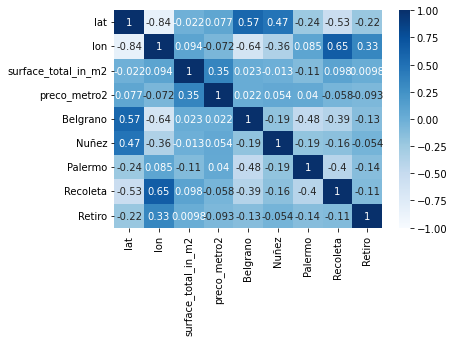

In [96]:
sns.heatmap(test.corr(), 
            annot = True, 
            vmin = -1, 
            cmap = 'Blues'
            );

In [98]:
feature_cols = ['lat', 'lon','surface_total_in_m2', 'Belgrano', 'Nuñez', 'Palermo','Recoleta', 'Retiro']
X = test[feature_cols]
y = test.preco_metro2
print('X:',X.shape)
print('y:',y.shape)


X: (4567, 8)
y: (4567,)


In [99]:
from sklearn.linear_model import LinearRegression

In [100]:
mo = LinearRegression()

In [101]:
mo.fit(X, y)

LinearRegression()

In [102]:
print (mo.intercept_)
print (mo.coef_)

-43031.174058046134
[ 1779.43125976 -1825.8553936      6.02758642    32.18529724
   258.95237262   248.50486411   -63.03941203  -476.60312195]


In [103]:
mo.score(X,y)

0.1446143955047936

In [104]:
y.shape

(4567,)

In [105]:
pred = mo.predict(X)

In [106]:
from sklearn import metrics
import numpy as np
print ('MAE:', metrics.mean_absolute_error(y, pred))
print ('MSE:', metrics.mean_squared_error(y, pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y, pred)))
print ('R2:', metrics.r2_score(y, pred))
print('MAPE: ',metrics.mean_absolute_percentage_error(y, pred))

MAE: 957.2250805965076
MSE: 1619722.0313067185
RMSE: 1272.6830050357073
R2: 0.1446143955047936
MAPE:  1.0279298121372854e+18


In [108]:
# Definios uma função e a chamamos de 'train_test_error', ela aceita como parâmetro uma lista de recursos (feature_cols),
# A função gera a matriz de variáveis independentes 'X' e a matriz da variável dependentes 'y'
# em seguida, ela faz a divisão entre conjuntos de treino e teste, reservando 25% das observações para teste,
# e finalmente imprime os erros MAE, MSE, RMSE e R2

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def train_test_error(feature_cols):
    
    vetor_r2 = 0;
    
    X = test[feature_cols]
    y = test['preco_metro2']
    # Como estamos trabalhando com observações ordenadas no tempo, usamos
    # `shuffle = False` para evitar data leakage
    for i in range(1000):
        X_train, X_test, y_train, y_test = train_test_split(X, y,)
        linreg = LinearRegression()
        linreg.fit(X_train, y_train)
        y_pred = linreg.predict(X_test)
        vetor_r2 = vetor_r2 + metrics.r2_score(y_test, y_pred)
    print("vetor R2", vetor_r2/i) 
    print (feature_cols)
    print ("y_test sample: ", y_test.values[0: 10])
    print ("y_pred sample: ", y_pred[0: 10].astype(int))
    print ('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print ('MSE:', metrics.mean_squared_error(y_test, y_pred))
    print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ('R2:', metrics.r2_score(y_test, y_pred))
    print('MAPE:',metrics.mean_absolute_percentage_error(y, pred))
    return

feature_cols = ['lat', 'lon','surface_total_in_m2', 'Belgrano', 'Nuñez', 'Palermo','Recoleta', 'Retiro']
train_test_error(feature_cols)

vetor R2 0.1403456265170846
['lat', 'lon', 'surface_total_in_m2', 'Belgrano', 'Nuñez', 'Palermo', 'Recoleta', 'Retiro']
y_test sample:  [   0.         2375.         2800.         2200.         3776.31578947
  376.18175624 3285.71428571 2788.46153846 3954.80225989 4375.        ]
y_pred sample:  [1471 2591 1934 2433 2236 2714 2301 2532 3614 2679]
MAE: 983.4492746273191
MSE: 1695177.4191834452
RMSE: 1301.9897922731366
R2: 0.11619830987792534
MAPE: 1.0279298121372854e+18


In [116]:
def train_test_rmse(feature_cols):
    X = test[feature_cols]
    y = test.preco_metro2
    # Como estamos trabalhando com observações ordenadas no tempo, podemos
    # usa shuffle = False para evitar data leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

train_test_rmse(['lat', 'lon','surface_total_in_m2', 'Belgrano', 'Nuñez', 'Palermo','Recoleta', 'Retiro'])

2330.8859958812536

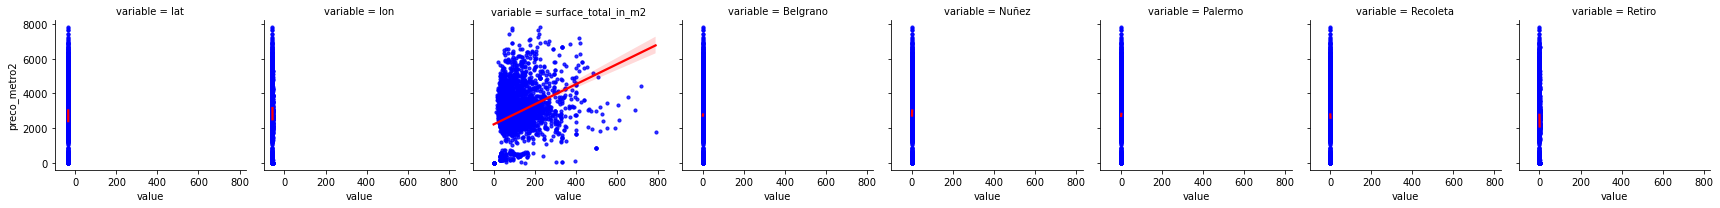

In [110]:
test_grid = pd.melt(test, id_vars = "preco_metro2", value_vars = ['lat', 'lon','surface_total_in_m2', 'Belgrano', 'Nuñez', 'Palermo','Recoleta', 'Retiro'])
g = sns.FacetGrid(test_grid, col = "variable")
g.map(sns.regplot, "value", "preco_metro2", ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"});

In [112]:
import statsmodels.api as sm
feature_cols = ['lat', 'lon','surface_total_in_m2', 'Belgrano', 'Nuñez', 'Palermo','Recoleta', 'Retiro']
X = df[feature_cols]
y = df.preco_metro2
# Temos que adicionar explicitamente a uma constante:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()


In [113]:
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:           preco_metro2   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     74.38
Date:                Thu, 30 Jun 2022   Prob (F-statistic):          1.01e-101
Time:                        12:33:38   Log-Likelihood:                -33858.
No. Observations:                4073   AIC:                         6.773e+04
Df Residuals:                    4065   BIC:                         6.778e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.107e+06   1

In [122]:
prop.place_name.unique()

array(['Mataderos', 'Belgrano', 'Palermo', 'Flores', 'Boedo',
       'Las Cañitas', 'Puerto Madero', 'Balvanera', 'Caballito', 'Nuñez',
       'Floresta', 'Barracas', 'Recoleta', 'Congreso', 'Villa Crespo',
       'Chacarita', 'Almagro', 'Constitución', 'Colegiales',
       'Villa Urquiza', 'Barrio Norte', 'Palermo Hollywood', 'Saavedra',
       'Paternal', 'Agronomía', 'Villa Pueyrredón', 'Coghlan',
       'Parque Centenario', 'San Telmo', 'Monserrat', 'Boca',
       'Parque Avellaneda', 'San Cristobal', 'Abasto', 'Versalles',
       'Villa del Parque', 'Monte Castro', 'Retiro', 'Capital Federal',
       'Parque Chas', 'Palermo Chico', 'Villa Devoto', 'Palermo Soho',
       'Centro / Microcentro', 'Liniers', 'Tribunales', 'Once',
       'San Nicolás', 'Parque Chacabuco', 'Velez Sarsfield', 'Catalinas',
       'Pompeya', 'Parque Patricios', 'Palermo Viejo', 'Villa Lugano',
       'Villa Luro', 'Villa General Mitre', 'Villa Ortuzar',
       'Villa Santa Rita', 'Villa Soldati', 'Villa Re

In [39]:
metros = pd.read_csv('Data/estaciones-de-subte.csv',sep=',')
bairros = ['Parque Patricios','Parque Patricios','San Cristóbal','Balvanera','Balvanera','San Nicolás',
           'Recoleta','San Nicolás','Recoleta','Palermo','Palermo','Palermo','Retiro','San Nicolás',
           'San Nicolás','Monserrat','Monserrat','Constitución','Constitución','San Nicolás','San Nicolás',
           'San Nicolás','Recoleta ','Balvanera','Balvanera','Balvanera','Almagro','Almagro','Villa Crespo',
           'Chacarita','Monserrat','Monserrat','Monserrat','Monserrat','Balvanera','Balvanera','Balvanera',
           'Balvanera','Almagro','Almagro','Almagro','Caballito','Caballito','Monserrat','Monserrat',
           'Monserrat','Constitución','San Cristóbal','San Cristóbal','San Cristóbal','San Cristóbal',
           'Caballito','Chacabuco','Palermo','Recoleta','Balvanera','Retiro','Constitución','Parque Chacabuco',
           'Boedo','Boedo','Palermo','Palermo','Belgrano','Belgrano','Chacarita','Flores','Flores',
           'San Nicolás','Monserrat','Belgrano','San Nicolás','Villa Ortúzar','Parque Chas','Flores',
           'Caballito','Balvanera','Parque Patricios','Parque Patricios','Villa Urquiza','Villa Urquiza',
           'Flores','Flores','Balvanera','Recoleta','Recoleta','Recoleta','Retiro','Retiro','San Nicolás']

barrios = pd.DataFrame({'bairros' : bairros})
df_metross = pd.concat([barrios,metros],axis = 1)
df_metross = df_metross.rename(columns={'long':'lon','estacion':'estação'})
df_metross = df_metross.drop(columns=['id','linea'])
df_metross

,bairros,lon,lat,estação
0,Parque Patricios,-58.398928,-34.635750,CASEROS
1,Parque Patricios,-58.400970,-34.629376,INCLAN - MEZQUITA AL AHMAD
2,San Cristóbal,-58.402323,-34.623092,HUMBERTO 1°
3,Balvanera,-58.404732,-34.615242,VENEZUELA
4,Balvanera,-58.406036,-34.608935,ONCE - 30 DE DICIEMBRE
...,...,...,...,...
85,Recoleta,-58.402376,-34.594525,SANTA FE - CARLOS JAUREGUI
86,Recoleta,-58.391019,-34.583036,FACULTAD DE DERECHO - JULIETA LANTERI
87,Retiro,-58.375850,-34.592114,RETIRO
88,Retiro,-58.371700,-34.596597,CATALINAS


In [40]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import geopy.distance

for x in df.index:
    ponto = (df['lon'][x], df['lat'][x])
    df.loc[x, 'distância até o metrô'] = min([geopy.distance.geodesic(ponto,(row.lon,row.lat)).meters for index, row in df_metross.iterrows()])
df.head()

,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,price_usd,preco_metro2,property_place,avg_price_m2,Belgrano,Nuñez,Palermo,Recoleta,Retiro,distância até o metrô
10106,Argentina,Capital Federal,-34.55527,-58.455786,180000.0,USD,77.0,180000.0,2337.662338,apartment_Belgrano,2921.998257,1,0,0,0,0,418.340602
11109,Argentina,Capital Federal,-34.56021,-58.469261,210000.0,USD,111.0,210000.0,1891.891892,apartment_Belgrano,2921.998257,1,0,0,0,0,811.707924
11110,Argentina,Capital Federal,-34.56021,-58.469261,114210.0,USD,42.0,114210.0,2719.285714,apartment_Belgrano,2921.998257,1,0,0,0,0,811.707924
11112,Argentina,Capital Federal,-34.56021,-58.469261,230000.0,USD,98.0,230000.0,2346.938776,apartment_Belgrano,2921.998257,1,0,0,0,0,811.707924
11113,Argentina,Capital Federal,-34.56021,-58.469261,263000.0,USD,113.0,263000.0,2327.433628,apartment_Belgrano,2921.998257,1,0,0,0,0,811.707924


In [43]:
#df = df.drop(columns = ['country_name','state_name','price','currency','price_usd','avg_price_m2','property_place'])
#df = df.drop(columns = ['Faixas_de_preco_m2'])
df

,lat,lon,surface_total_in_m2,preco_metro2,Belgrano,Nuñez,Palermo,Recoleta,Retiro,distância até o metrô
10106,-34.555270,-58.455786,77.0,2337.662338,1,0,0,0,0,418.340602
11109,-34.560210,-58.469261,111.0,1891.891892,1,0,0,0,0,811.707924
11110,-34.560210,-58.469261,42.0,2719.285714,1,0,0,0,0,811.707924
11112,-34.560210,-58.469261,98.0,2346.938776,1,0,0,0,0,811.707924
11113,-34.560210,-58.469261,113.0,2327.433628,1,0,0,0,0,811.707924
...,...,...,...,...,...,...,...,...,...,...
9444,-34.597040,-58.378666,52.0,3837.596154,0,0,0,0,1,149.532119
9582,-34.586849,-58.384689,161.0,2919.254658,0,0,0,0,1,739.507263
9919,-34.592865,-58.381134,166.0,3012.048193,0,0,0,0,1,390.918836
10455,-34.591852,-58.376688,70.0,3285.714286,0,0,0,0,1,94.656728


In [44]:
df['Faixas_de_preco_m2'] = pd.qcut(x = df.preco_metro2, q = 10, labels = [1,2,3,4,5,6,7,8,9,10])

In [45]:
dum = pd.get_dummies(df.Faixas_de_preco_m2)
df = pd.concat([df,dum],axis=1)


In [46]:
df.columns

Index([                  'lat',                   'lon',
         'surface_total_in_m2',          'preco_metro2',
                    'Belgrano',                 'Nuñez',
                     'Palermo',              'Recoleta',
                      'Retiro', 'distância até o metrô',
          'Faixas_de_preco_m2',                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10],
      dtype='object')

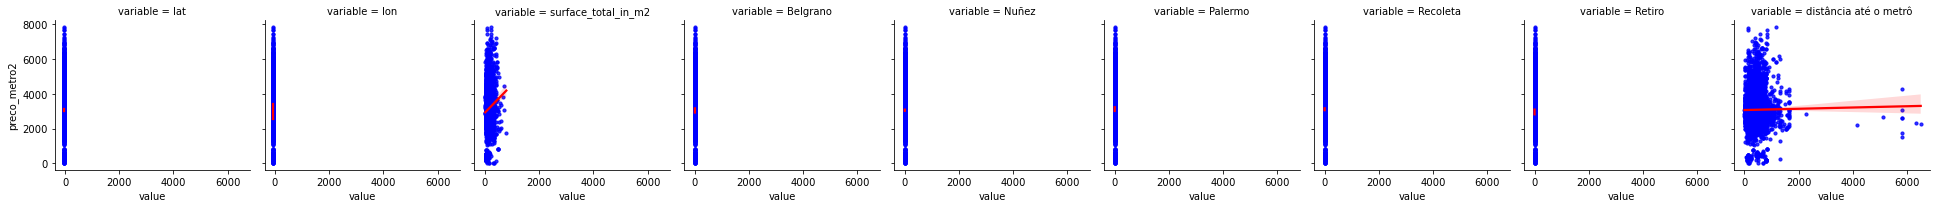

In [47]:
df_grid = pd.melt(df, id_vars = "preco_metro2", value_vars = ['lat','lon','surface_total_in_m2','Belgrano','Nuñez','Palermo','Recoleta','Retiro','distância até o metrô'])
g = sns.FacetGrid(df_grid, col = "variable")
g.map(sns.regplot, "value", "preco_metro2", ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"});

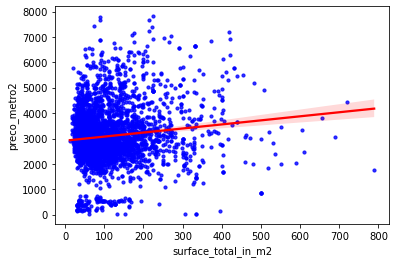

In [49]:
sns.regplot(data = df, x = "surface_total_in_m2", y = "preco_metro2", ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"});

In [50]:
import statsmodels.api as sm
feature_cols = ['lat',                   'lon',
         'surface_total_in_m2',              'Belgrano',
                      'Nuñez',
                     'Palermo',              'Recoleta',
                      'Retiro',                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10, 'distância até o metrô']
X = df[feature_cols]
y = df.preco_metro2
# Temos que adicionar explicitamente a uma constante:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:           preco_metro2   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     2158.
Date:                Sat, 02 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:57:14   Log-Likelihood:                -29405.
No. Observations:                4073   AIC:                         5.885e+04
Df Residuals:                    4055   BIC:                         5.896e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  8.871e+

In [52]:
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
  
random.seed(3)
feature_cols = ['lat',                   'lon',
         'surface_total_in_m2',              'Belgrano',
                      'Nuñez',
                     'Palermo',              'Recoleta',
                      'Retiro',                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10, 'distância até o metrô']
X = df[feature_cols]
y = df.preco_metro2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

lr = linear_model.LinearRegression()
cv = KFold(5, 
           shuffle = True
          )
scores = cross_val_score(lr, 
                         X_train, 
                         y_train, 
                         cv = cv, 
                         scoring = 'r2'
                        )
scores, scores.mean()

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature name

(array([0.89728167, 0.88968067, 0.90215846, 0.90299672, 0.90865777]),
 0.9001550556681291)

In [53]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model

LinearRegression()

In [54]:
feature_cols = ['lat',                   'lon',
         'surface_total_in_m2',              'Belgrano',
                      'Nuñez',
                     'Palermo',              'Recoleta',
                      'Retiro',                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10, 'distância até o metrô']
X = df[feature_cols]
y = df['preco_metro2']

print("Shape X:", X.shape)
print("Type X:", type(X))
print("Shape y:", y.shape)
print("Type y:", type(y))

Shape X: (4073, 19)
Type X: <class 'pandas.core.frame.DataFrame'>
Shape y: (4073,)
Type y: <class 'pandas.core.series.Series'>


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 1
                                                   )
model.fit(X_train,y_train)

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


LinearRegression()

In [56]:
model.coef_

array([ 1.89775443e+03,  1.20685906e+03,  4.55578561e-01, -2.87263488e+01,
        2.60676749e+01,  1.57246523e+00, -5.93432422e+01,  6.04294509e+01,
       -1.77143127e+03, -7.62955353e+02, -5.30542892e+02, -3.63383227e+02,
       -1.94991721e+02, -2.74550512e+01,  1.66547756e+02,  4.56294787e+02,
        9.09223173e+02,  2.11869379e+03,  2.33414918e-02])

In [57]:
model.intercept_

139174.73820610627

In [58]:
model.predict(X)

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([2302.5888886 , 1293.14676564, 2669.75988464, ..., 3185.89902294,
       3336.53958854, 3113.34246877])

In [59]:
test_sklearn = np.array(X_test).reshape(-19,19)
model.predict(test_sklearn)

array([3458.30047266, 1267.44072087, 2292.40502742, ..., 2661.15276079,
       2275.80716623, 2714.12160614])

In [60]:
y_pred = model.predict(X_test)
y_pred

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([3458.30047266, 1267.44072087, 2292.40502742, ..., 2661.15276079,
       2275.80716623, 2714.12160614])

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
print ('MAE:', mean_absolute_error(y_test, y_pred).round(2))
print ('MSE:', mean_squared_error(y_test, y_pred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)).round(2))
print ('R2:', r2_score(y_test, y_pred).round(2))
print('MAPE', mean_absolute_percentage_error(y_test, y_pred).round(2))

MAE: 181.77
MSE: 104140.84
RMSE: 322.71
R2: 0.9
MAPE 0.22


In [62]:
df

,lat,lon,surface_total_in_m2,preco_metro2,Belgrano,Nuñez,Palermo,Recoleta,Retiro,distância até o metrô,...,1,2,3,4,5,6,7,8,9,10
10106,-34.555270,-58.455786,77.0,2337.662338,1,0,0,0,0,418.340602,...,0,1,0,0,0,0,0,0,0,0
11109,-34.560210,-58.469261,111.0,1891.891892,1,0,0,0,0,811.707924,...,1,0,0,0,0,0,0,0,0,0
11110,-34.560210,-58.469261,42.0,2719.285714,1,0,0,0,0,811.707924,...,0,0,0,1,0,0,0,0,0,0
11112,-34.560210,-58.469261,98.0,2346.938776,1,0,0,0,0,811.707924,...,0,1,0,0,0,0,0,0,0,0
11113,-34.560210,-58.469261,113.0,2327.433628,1,0,0,0,0,811.707924,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9444,-34.597040,-58.378666,52.0,3837.596154,0,0,0,0,1,149.532119,...,0,0,0,0,0,0,0,0,1,0
9582,-34.586849,-58.384689,161.0,2919.254658,0,0,0,0,1,739.507263,...,0,0,0,0,1,0,0,0,0,0
9919,-34.592865,-58.381134,166.0,3012.048193,0,0,0,0,1,390.918836,...,0,0,0,0,0,1,0,0,0,0
10455,-34.591852,-58.376688,70.0,3285.714286,0,0,0,0,1,94.656728,...,0,0,0,0,0,0,1,0,0,0


In [63]:
# Ajustamos o modelo usando somente as variables quantitativas e MCO
feature_cols = ['lat',                   'lon',
         'surface_total_in_m2',              'Belgrano',
                      'Nuñez',
                     'Palermo',              'Recoleta',
                      'Retiro',                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10, 'distância até o metrô']
X = df[feature_cols]
y = df['preco_metro2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, 
                                                    random_state = 10
                                                   )

lm = linear_model.LinearRegression()

model_1 = lm.fit(X_train, y_train)

print('Score model_1:', model_1.score(X_test, y_test))

Score model_1: 0.8991325162386373


C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [64]:
# Ajustamos o modelo usando somente as variáveis quantitativas aplicando regularização
# É necessário normalizar as `features` antes de aplicar a regularização neste caso? Quais unidades têm os recursos?

lm_ridge = linear_model.RidgeCV(alphas = [0.1, 1, 10], 
                                normalize = True
                               ) 
# Definimos o intervalo de busca do híper-parâmetro explicitamente

model_2 = lm_ridge.fit(X_train, y_train)

print('Score model_2:', model_2.score(X_test, y_test))

# Melhoraram os resultados?

Score model_2: 0.8881813597404036


C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alphas to: original_alphas * n_samples. 
  warnings.warn(
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(

In [65]:
# Agora treinamos o modelo com todas as variáveis com Lasso:

lm_lasso = linear_model.LassoCV(alphas = [0,0.025,0.5],
                                normalize = True, 
                                cv = 3
                               )

model_5 = lm_lasso.fit(X_train, y_train)

print('Score model_5:', model_5.score(X_test, y_test))

Score model_5: 0.8989362950006489


C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90437135.99614668, tolerance: 187483.5978826579
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\line